## 1: Import necessary libraries

In [1]:
!pip install split-folders

In [2]:
# !nvidia-smi

In [3]:
import os
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
import splitfolders
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [5]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image

In [6]:
%matplotlib inline

## 2: Uploading and Preparing the Dataset

In [7]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Defining the path to the dataset zip file
data_dir = '/content/drive/My Drive/data.zip'

Mounted at /content/drive


### 2.1: Extracting the Zip File

In [8]:
# Setting up the directory to extract the contents of the dataset
extract_to_dir = '/content/extracted_data'

# Extracting the zip file to the designated directory
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# Verifying the contents of the extracted dataset
extracted_contents = os.listdir(extract_to_dir)
print(f"Contents of '{extract_to_dir}': {extracted_contents}")

Contents of '/content/extracted_data': ['Data']


### 2.2: Splitting the Data

In [9]:
# Specifying the paths for input data and the destination for the split data
input_folder = '/content/extracted_data/Data'  # Adjust path as per your directory structure
output_folder = '/content/train_val_data'  # The split data will be saved here

# Splitting the data into training and validation sets with a predefined seed for reproducibility
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2))

Copying files: 47113 files [00:08, 5318.71 files/s]


In [10]:
# Listing contents of the output folder to check the split
if os.path.exists(output_folder):
    output_folder_contents = os.listdir(output_folder)
    print(f"Contents of '{output_folder}': {output_folder_contents}")

Contents of '/content/train_val_data': ['train', 'val']


In [11]:
# Defining paths for the training and validation datasets
train_dir = os.path.join(output_folder, 'train')
valid_dir = os.path.join(output_folder, 'val')

### 2.3: Visualizing and Analyzing the Dataset Distribution

In [12]:
# Function to visualize the distribution of images in the training and validation datasets
def plot_train_val_distribution(train_dir, val_dir, num_classes):
    # Retrieving class names from the directories
    train_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    val_classes = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))]

    # Confirming that both datasets have the same classes and sorting them
    assert set(train_classes) == set(val_classes)
    classes = sorted(train_classes)[:num_classes]

    # Calculating the number of images per class
    train_counts, val_counts = [], []
    for class_name in classes:
        train_counts.append(len(os.listdir(os.path.join(train_dir, class_name))))
        val_counts.append(len(os.listdir(os.path.join(val_dir, class_name))))

    # Plotting the distribution of the number of images per class
    x = np.arange(len(classes))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.bar(x - width/2, train_counts, width, label='Train')
    ax.bar(x + width/2, val_counts, width, label='Validation')
    ax.set_ylabel('Number of images')
    ax.set_title('Number of images per class in training and validation sets')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, fontsize=7, rotation=90)
    ax.legend()
    plt.show()

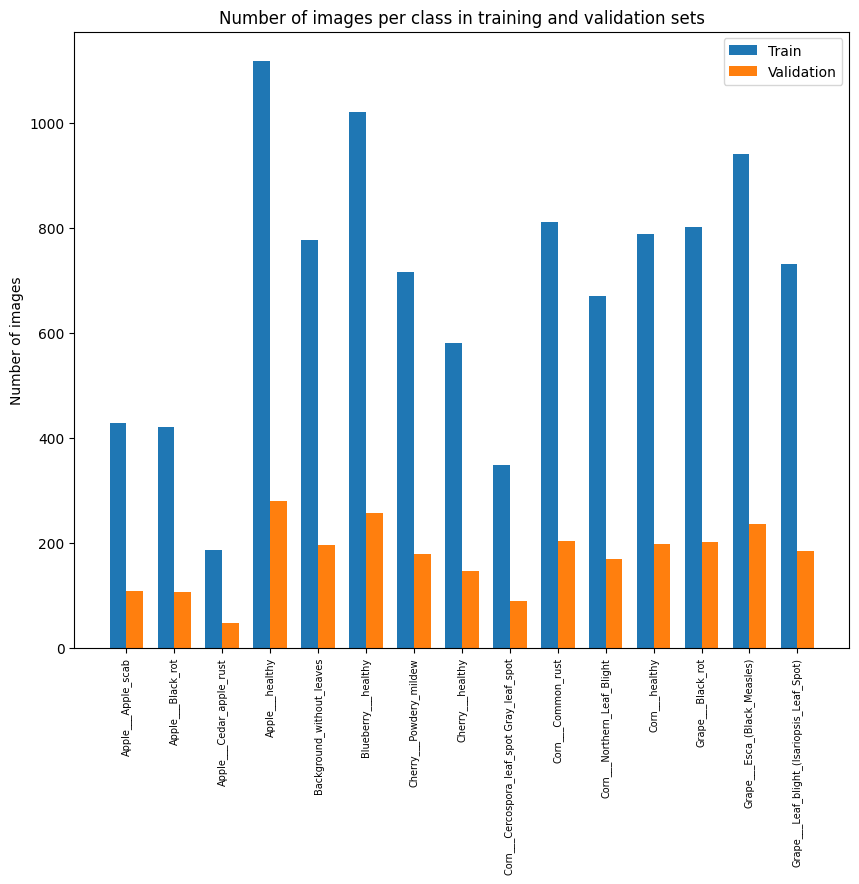

In [13]:
# Executing the function to display the plot with a specific number of classes
plot_train_val_distribution(train_dir, valid_dir, num_classes=15)

### 2.4: Verifying the 80:20 Dataset Split

In [14]:
# Check the consistency of the dataset split by printing the number of images per class
class_names = os.listdir(train_dir)

# Display the number of images for the first 5 classes
for class_name in class_names[:5]:
    train_class_path = os.path.join(train_dir, class_name)
    valid_class_path = os.path.join(valid_dir, class_name)

    # Counting the number of images in the training and validation directories for each class
    num_train_images = len(os.listdir(train_class_path))
    num_valid_images = len(os.listdir(valid_class_path))

    # Printing out the class name and the respective image counts for both training and validation
    print(f"Class: {class_name}")
    print(f"Number of Training Images: {num_train_images}")
    print(f"Number of Validation Images: {num_valid_images}")
    print("-" * 35)  # A separator for better readability of output

Class: Orange___Haunglongbing_(Citrus_greening)
Number of Training Images: 3744
Number of Validation Images: 936
-----------------------------------
Class: Tomato___healthy
Number of Training Images: 1081
Number of Validation Images: 271
-----------------------------------
Class: Grape___Esca_(Black_Measles)
Number of Training Images: 940
Number of Validation Images: 235
-----------------------------------
Class: Apple___healthy
Number of Training Images: 1118
Number of Validation Images: 280
-----------------------------------
Class: Corn___Common_rust
Number of Training Images: 810
Number of Validation Images: 203
-----------------------------------


## 3: Exploring the Data Classes

### 3.1: Identifying Classes of Each Disease

In [15]:
# Listing the disease classes from the training directory and displaying the total count
diseases = os.listdir(train_dir)
print("Total Disease classes: {}".format(len(diseases)))
print("-" * 25)
# Displaying the first five disease classes to verify the contents
print(diseases[0:5])

Total Disease classes: 39
-------------------------
['Orange___Haunglongbing_(Citrus_greening)', 'Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Apple___healthy', 'Corn___Common_rust']


### 3.2: Overview of Plants and Associated Diseases

In [16]:
# Initializing lists to hold unique plant names and disease classes
plants = []
disease_classes = []
NumberOfDiseases = 0

# Iterating over the disease classes to segregate plant names and disease types
for plant in diseases:
    parts = plant.split('___')
    # Splitting based on the delimiter to separate the plant name from the disease class
    if len(parts) > 1:
        plant, disease = parts[0], '___'.join(parts[1:])
        # Populating the lists with unique plant names and disease classes
        if plant not in plants:
            plants.append(plant)
        # Excluding the 'healthy' class to count only the diseases
        if disease != 'healthy':
            disease_classes.append(disease)
            NumberOfDiseases += 1

# Printing the number of diseases and displaying the first five for verification
print("Number of diseases: {}".format(NumberOfDiseases))
print("-" * 22)
print(disease_classes[0:5])

print("=" * 130)

# Printing the number of unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print("-" * 20)
# Displaying the first five plant names
print(plants[0:5])

Number of diseases: 26
----------------------
['Haunglongbing_(Citrus_greening)', 'Esca_(Black_Measles)', 'Common_rust', 'Cercospora_leaf_spot Gray_leaf_spot', 'Early_blight']
Number of plants: 14
--------------------
['Orange', 'Tomato', 'Grape', 'Apple', 'Corn']


### 3.3: Reporting on the Number of Diseases and Plants

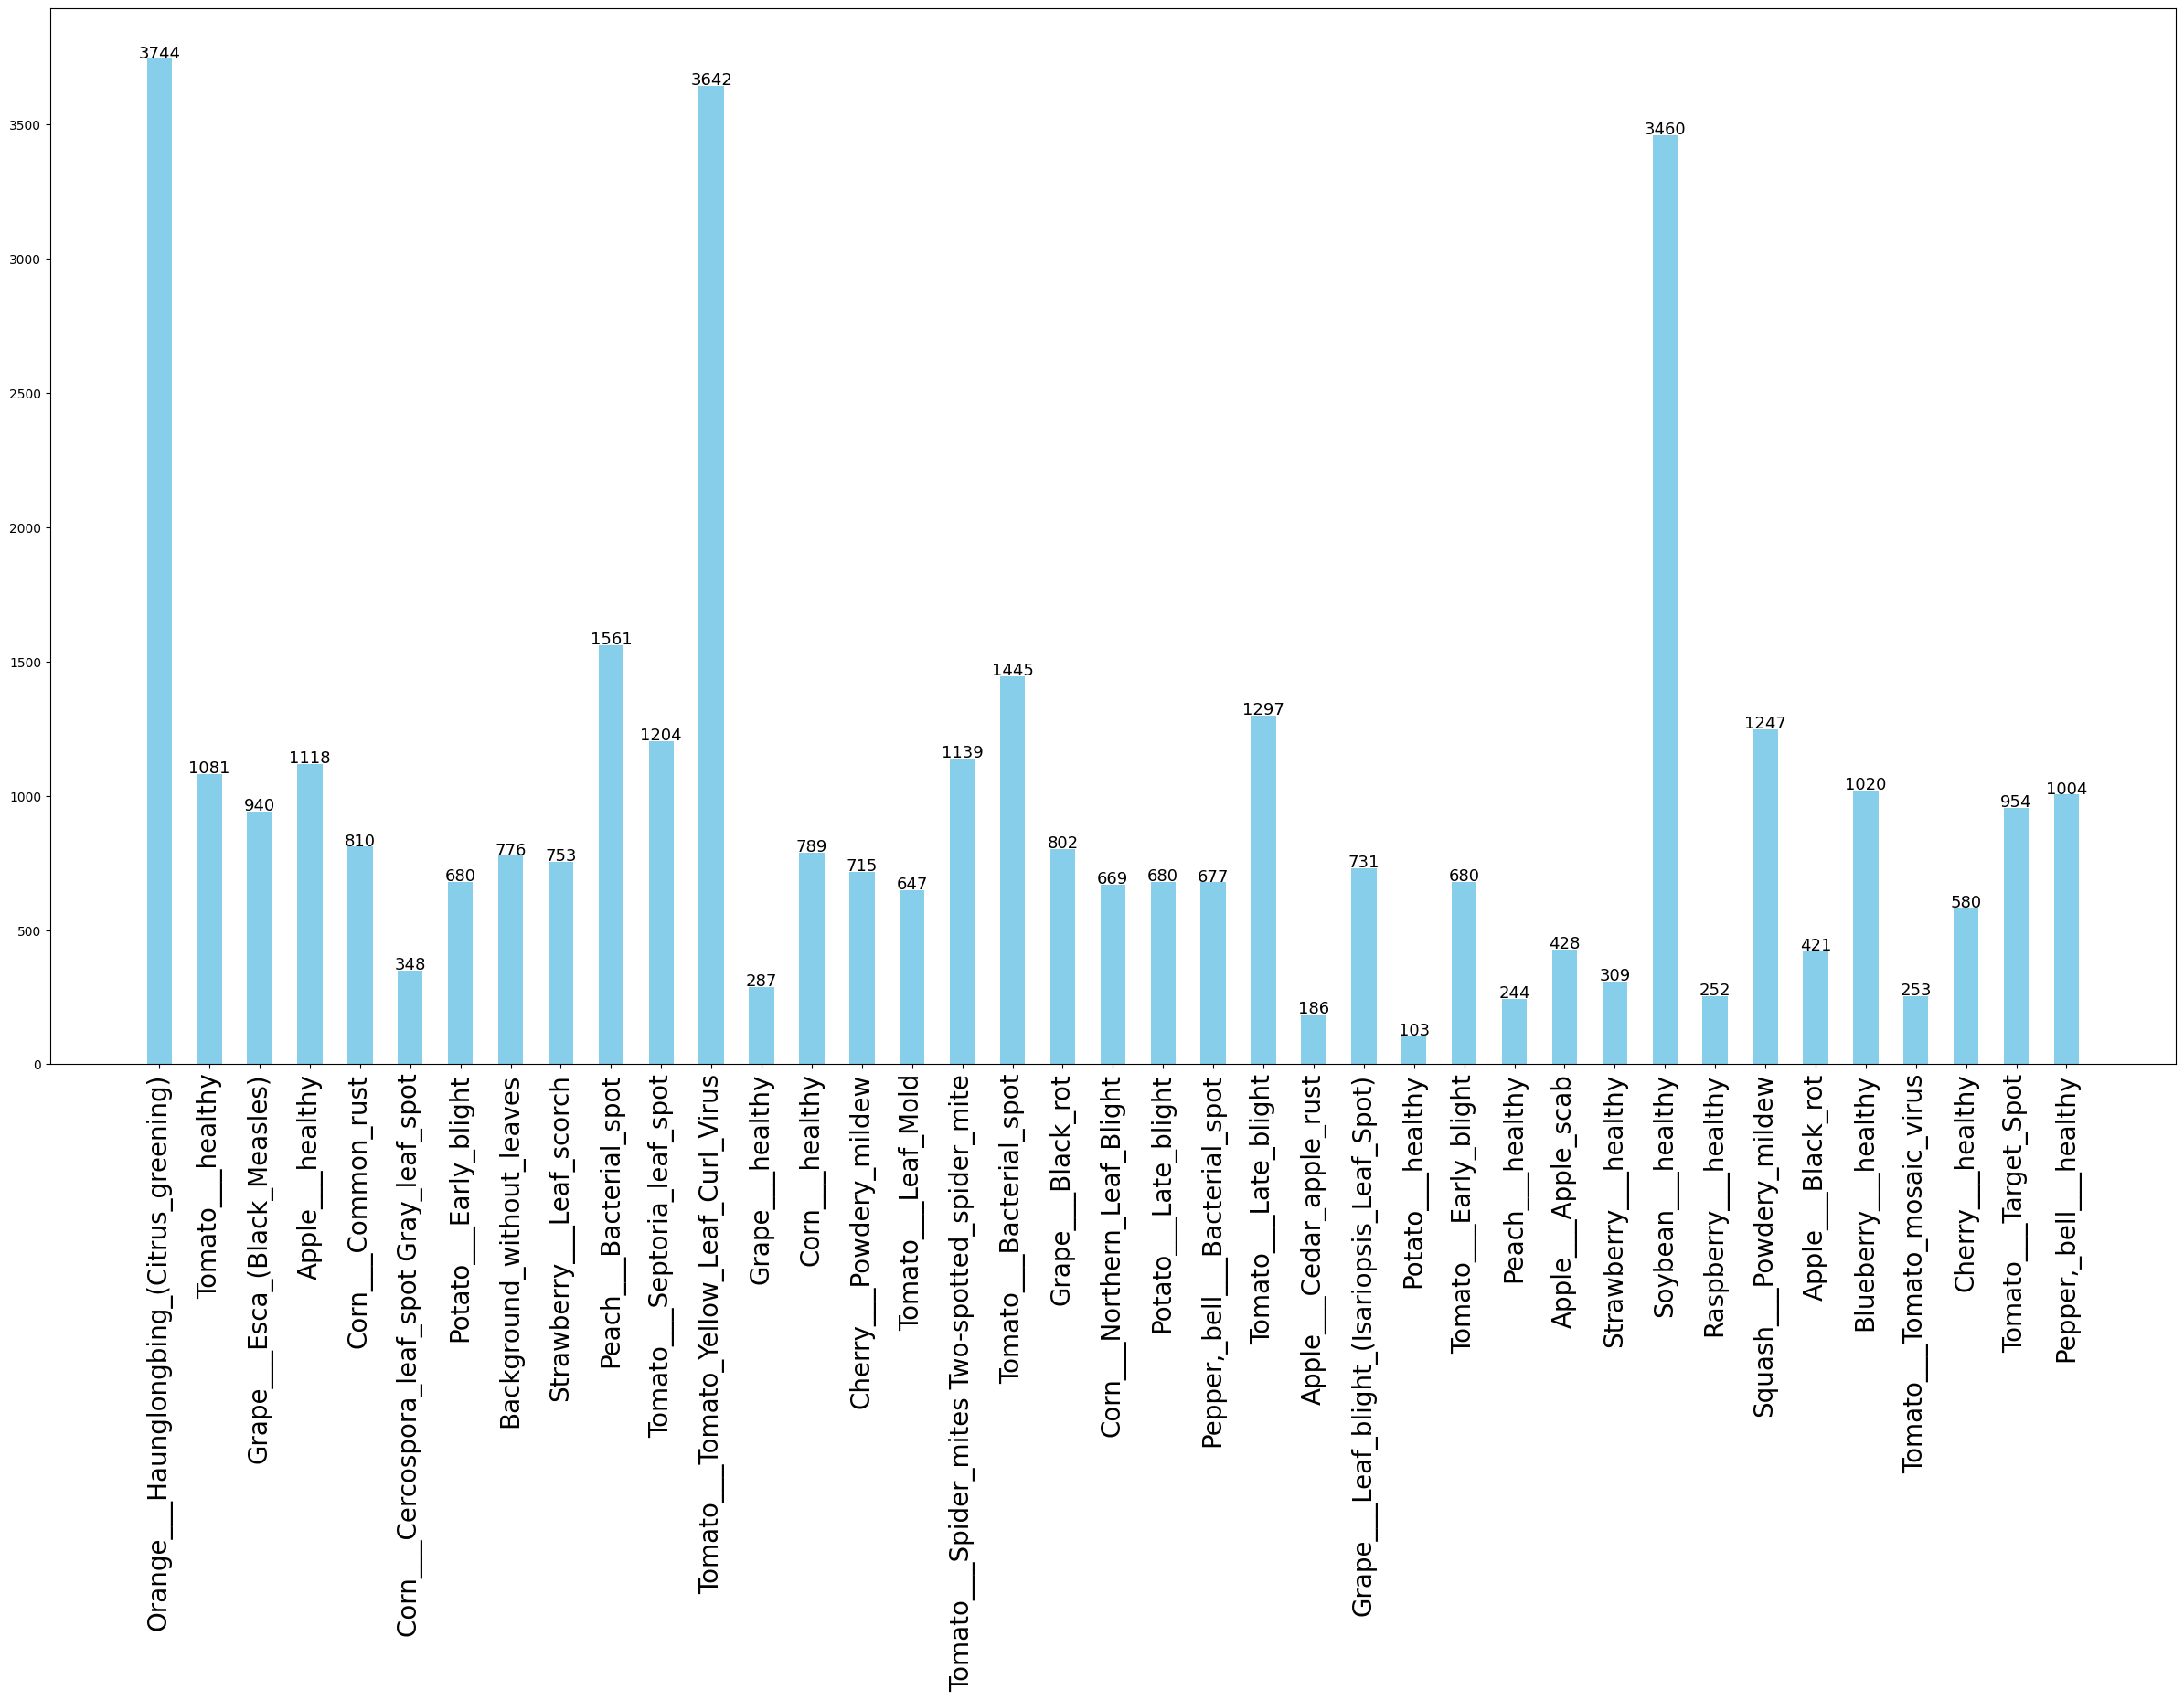

In [17]:
# Creating a dictionary to hold the count of images per disease class
nums = {}
for disease in diseases:
    # Populating the dictionary with the disease class as key and image count as value
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# Converting the dictionary to a pandas DataFrame for better visualization
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])

# Plotting the number of images available for each disease class
index = [n for n in range(len(diseases))]
plt.figure(figsize=(30, 15))
plt.bar(index, [n for n in nums.values()], width=0.5, color='skyblue')
plt.xticks(index, diseases, fontsize=20, rotation=90)

# Adding text labels above the bars to display the count of images
for i, v in enumerate(nums.values()):
    plt.text(i, v + 5, str(v), color='black', ha='center', fontsize=13)

plt.show()

## 4: Data Preprocessing

### 4.1: Data Augmentation and Transformation

In [18]:
# Paths to your augmented data directory
augmented_train_dir = '/content/augmented_train_dir'

In [19]:
# Training Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Random crops
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),  # Vertical flip
    transforms.RandomRotation(20),  # Random rotations
    transforms.ToTensor()
])

# Validation Data Transformation (No Augmentation)
valid_transforms = transforms.Compose([
    transforms.ToTensor()  # Convert the image to a tensor
])

In [20]:
# Function to apply augmentation to an image
def apply_augmentation(image_path, output_path, transform):
        image = Image.open(image_path)
        augmented_image = transform(image)
        # Convert the tensor back to a PIL image
        pil_image = to_pil_image(augmented_image)
        pil_image.save(output_path)

# Function to augment a subset of images in a directory
def augment_all_images(input_dir, output_dir, transform):
    # Iterate over all class directories in the input directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)

        # Skip if not a directory
        if not os.path.isdir(class_dir):
            continue

        # Make a corresponding directory in the output directory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image file in the class directory
        for image_file in os.listdir(class_dir):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_path = os.path.join(class_dir, image_file)
                output_path = os.path.join(output_class_dir, 'aug_' + image_file)
                apply_augmentation(input_path, output_path, transform)

In [21]:
# Augment the training images
augment_all_images(train_dir, augmented_train_dir, train_transforms)

In [22]:
# Function to copy augmented images into the training directory
def merge_augmented_images(augmented_dir, original_dir):
    # Check if the augmented directory exists
    if not os.path.isdir(augmented_dir):
        print(f"Directory not found: {augmented_dir}")
        return

    for filename in os.listdir(augmented_dir):
        source = os.path.join(augmented_dir, filename)
        destination = os.path.join(original_dir, filename)
        if os.path.isfile(source):
            shutil.copy(source, destination)

In [23]:
# Merge the augmented images into the training directory
merge_augmented_images(augmented_train_dir, train_dir)

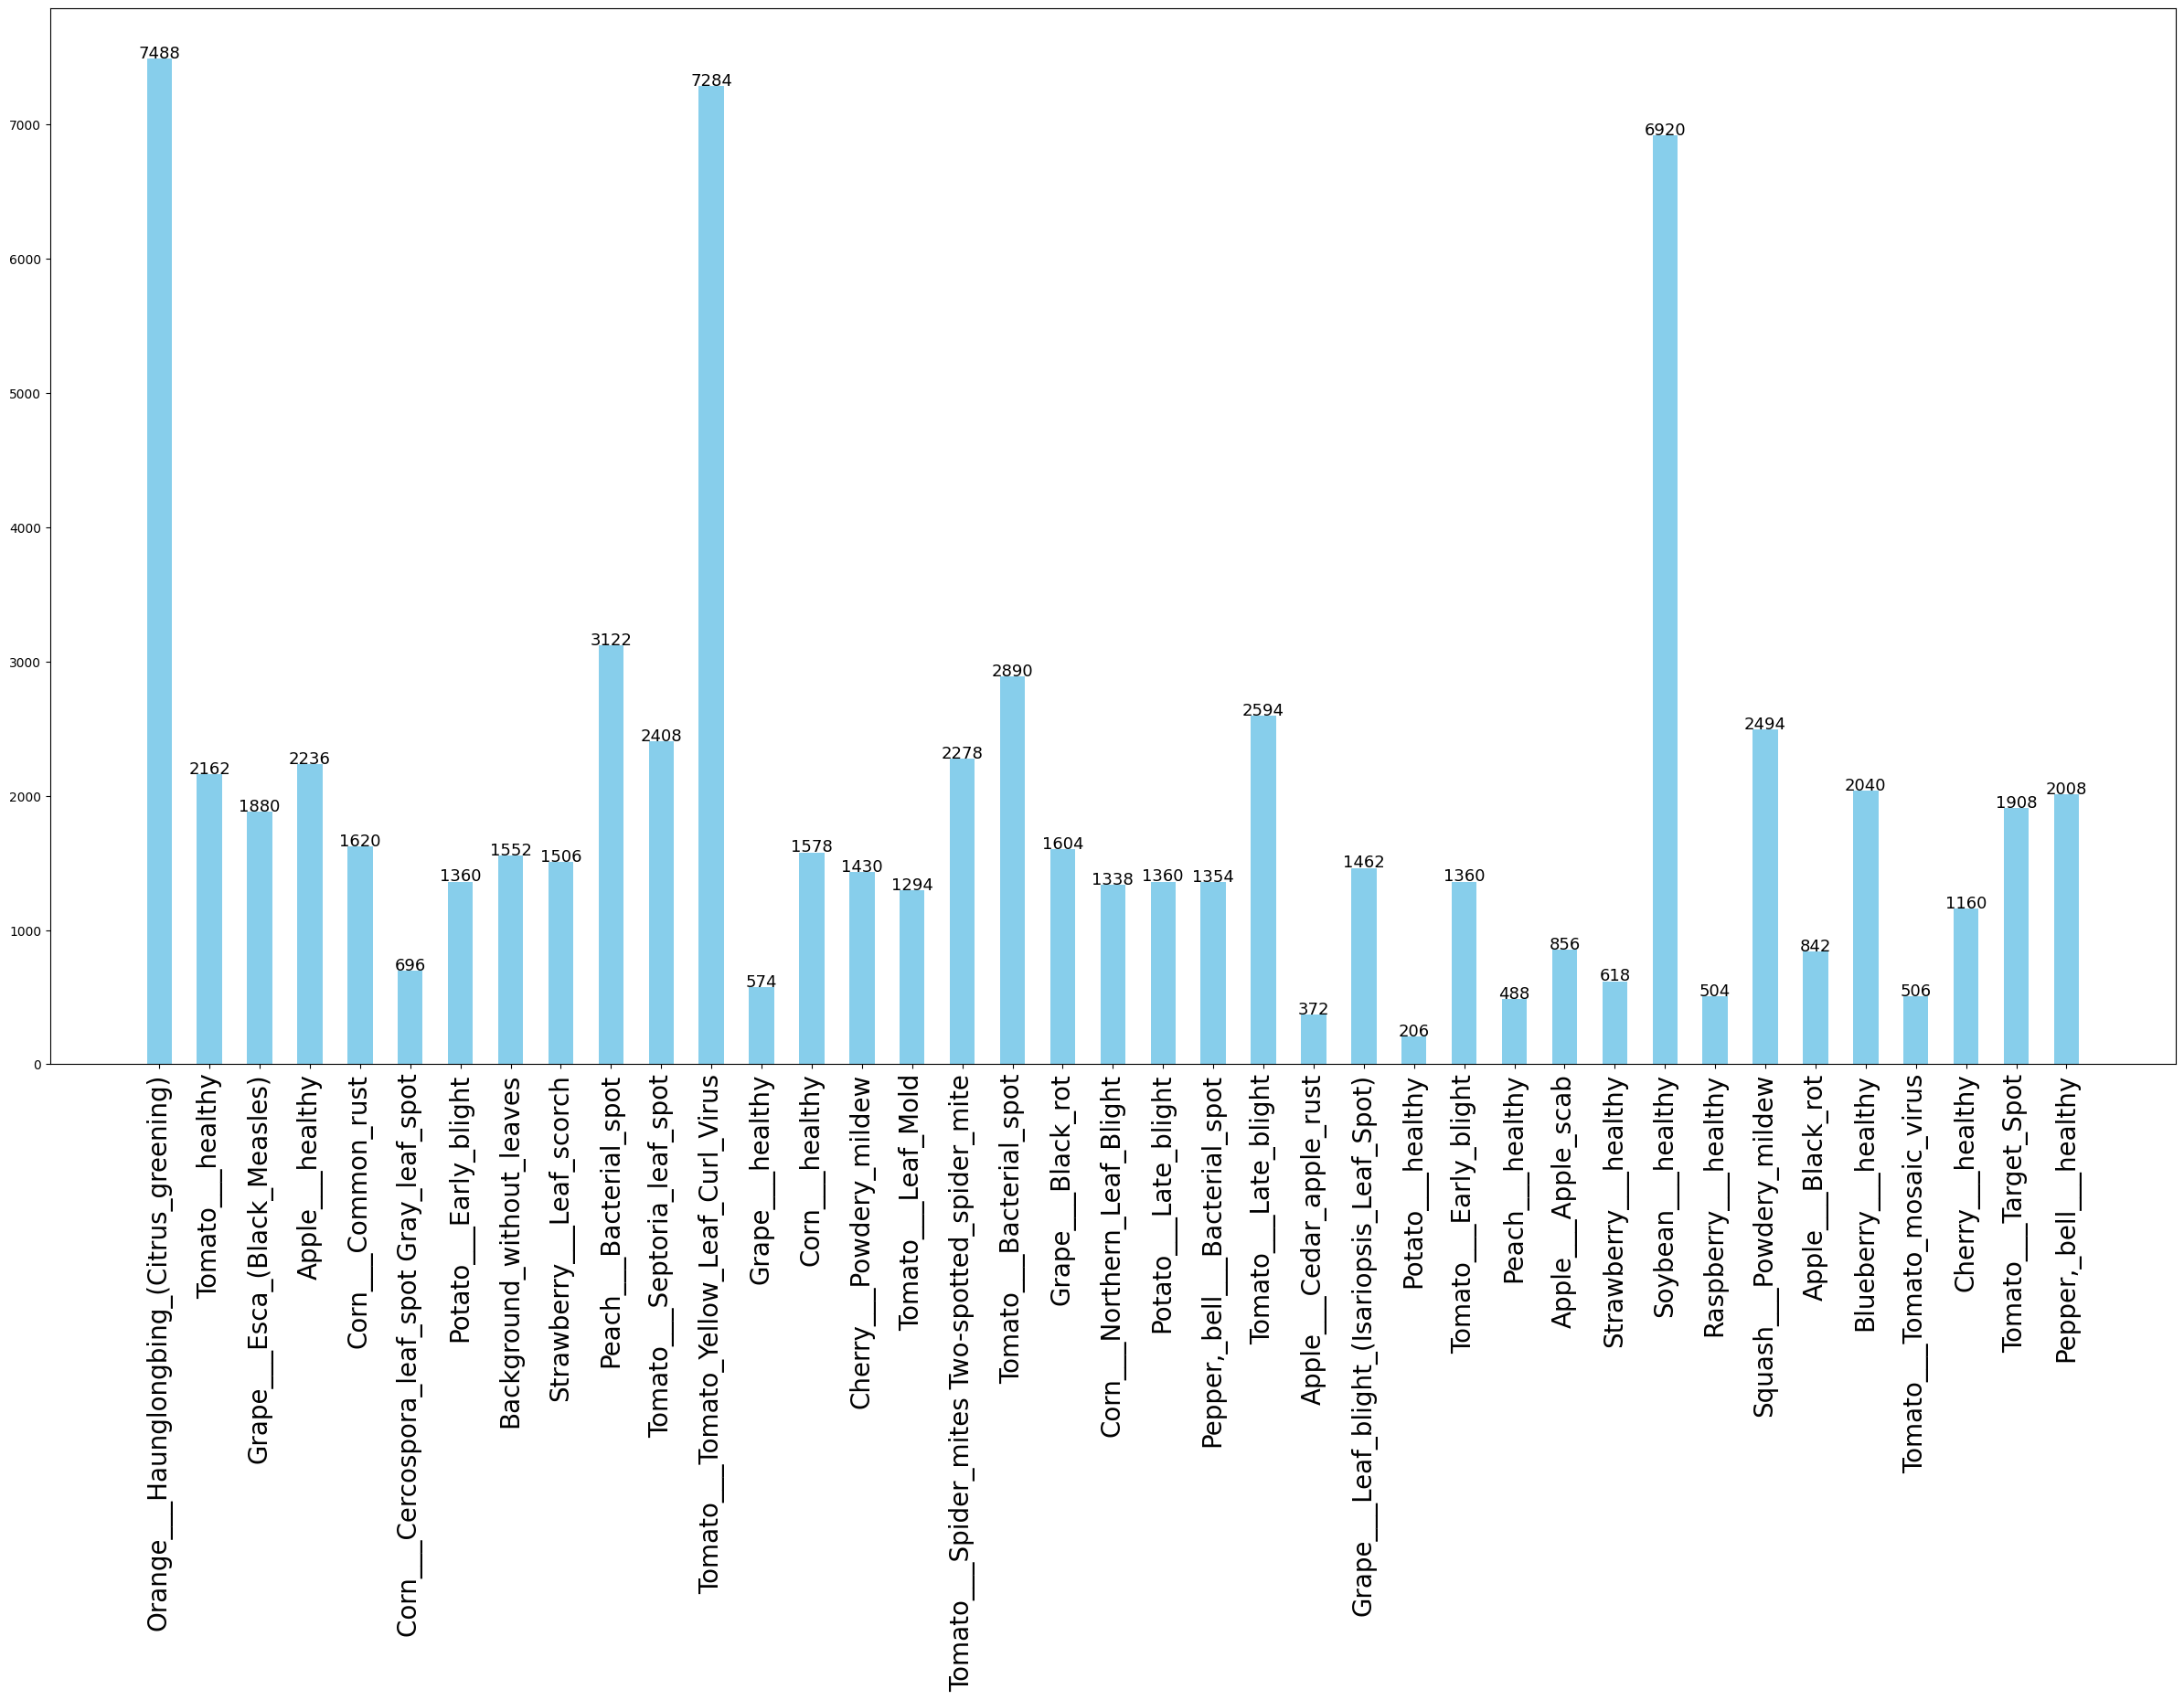

In [24]:
# Create a dictionary to hold the count of images per disease class, including augmented images
nums = {}
for disease in diseases:
    # Get the list of image files in the class directory (original images)
    original_images = os.listdir(os.path.join(train_dir, disease))

    # Get the list of augmented image files in the class directory
    augmented_images = os.listdir(os.path.join(augmented_train_dir, disease))

    # Calculate the total count of images, including both original and augmented
    total_images = len(original_images) + len(augmented_images)

    # Populate the dictionary with the disease class as the key and the total image count as the value
    nums[disease] = total_images

# Convert the dictionary to a pandas DataFrame for better visualization
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])

# Plot the number of images available for each disease class, including both original and augmented
index = [n for n in range(len(diseases))]
plt.figure(figsize=(30, 15))
plt.bar(index, [n for n in nums.values()], width=0.5, color='skyblue')
plt.xticks(index, diseases, fontsize=20, rotation=90)

# Adding text labels above the bars to display the count of images
for i, v in enumerate(nums.values()):
    plt.text(i, v + 5, str(v), color='black', ha='center', fontsize=13)

plt.show()

In [25]:
# Now, create your datasets using ImageFolder
train = ImageFolder(root=train_dir, transform=train_transforms)
valid = ImageFolder(root=valid_dir, transform=valid_transforms)

In [26]:
# Displaying the shape of an image tensor and its corresponding label to verify the conversion
img, label = train[0]
print(img.shape, label)  # Output format: (channels, height, width), label

torch.Size([3, 256, 256]) 0


### 4.2: Checking Training Images

In [27]:
# Defining a function to visualize images from the training dataset
def show_image(image, label):
    # Printing the label and corresponding numerical class of the image
    print("Label: " + train.classes[label] + " (" + str(label) + ")")
    # The image tensor is permuted to match the image's (height, width, channels) layout for display
    plt.imshow(image.permute(1, 2, 0))

Label: Apple___Apple_scab (0)


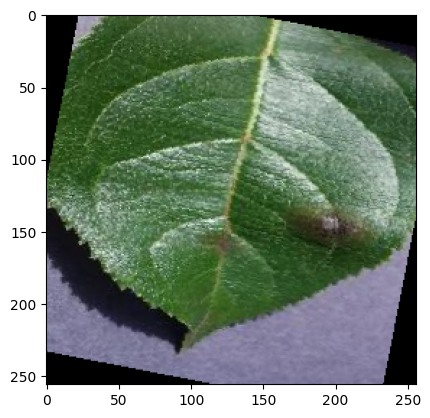

In [28]:
# Visualizing the first image in the training dataset using the function defined above
show_image(*train[0])

Label: Tomato___Septoria_leaf_spot (33)


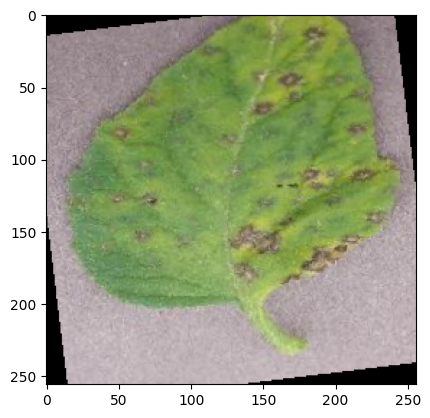

In [29]:
# Visualizing another image (at index 30000) from the training dataset
show_image(*train[30000])

### 4.3: Generating Patches

In [30]:
# Defining a helper function to show a batch of training instances
def show_batch(data):
    # Iterating through the DataLoader to fetch a batch of images
    for images, labels in data:
        # Plotting the batch of images using make_grid to organize them into a grid format
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break  # Breaking after the first batch to only show one batch

In [31]:
# Configuring the random seed for deterministic behavior during data shuffling
random_seed = 7
torch.manual_seed(random_seed)

In [32]:
# Defining the batch size for loading the dataset in mini-batches during training
batch_size = 16

In [33]:
# Creating DataLoader instances for training and validation datasets
# DataLoader allows for batch processing, shuffling of the dataset, and parallel data loading
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

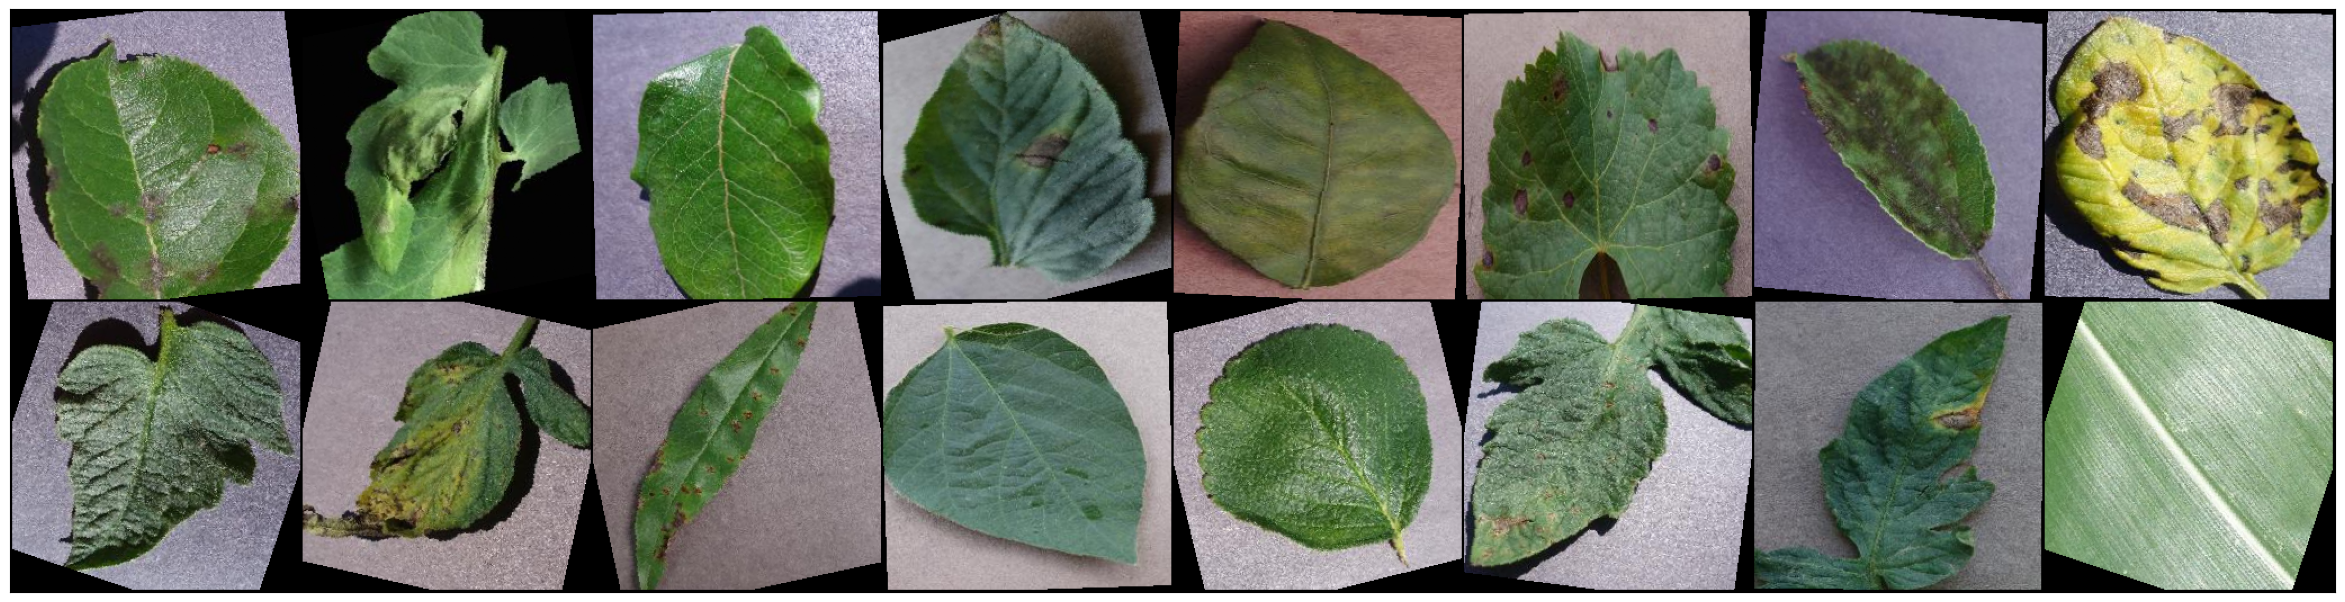

In [34]:
# Displaying the first batch of images from the training DataLoader
show_batch(train_dl)

## 5:Environment Setup

### 5.1: Device Management

In [35]:
# Defining a function to choose the default device for training (GPU if available, else CPU)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Function to move data or model to the chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [36]:
# Creating a class that wraps a DataLoader to move batches to the specified device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
# Identifying the default device for training (GPU if available, otherwise CPU)
device = get_default_device()
device

device(type='cuda')

In [38]:
# Wrapping the training and validation DataLoaders for automatic device assignment
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### 5.2: Residual Block Implementation

In [39]:
# Implementing a simple residual block for a neural network
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining two convolutional layers followed by ReLU activations
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        # Forward pass through the layers with a skip connection
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x  # Adding the input to the output before activation

### 5.3: Accuracy Function Implementation

In [40]:
# Defining a function to calculate the accuracy of model predictions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Implementing a base class for image classification models
class ImageClassificationBase(nn.Module):
    # Methods for training step, validation step, end of validation epoch, and end of epoch logging
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

### 5.4: Convolution Block with BatchNormalization

In [41]:
# Function to create a convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

### 5.5: ResNet Architecture

In [42]:
# Defining the ResNet9 model architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        # Convolution blocks and residual connections
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb):
        # Defining the forward pass of the model
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### 5.6: Model Summary

In [43]:
# Creating an instance of the ResNet9 model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device)

# Getting a summary of the model to verify the architecture
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

## 6: Training the model

### 6.1: Model Evaluation

In [44]:
# Defining a function to evaluate the model's performance on the validation set
@torch.no_grad()  # Decorator to ensure that computations in this function are not tracked for gradients
def evaluate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]  # Collecting the validation steps over all batches
    return model.validation_epoch_end(outputs)  # Aggregate the results at the end of the epoch

### 6.2: Learning Rate Scheduler

In [45]:
# Function to fetch the current learning rate from the optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

### 6.3: Model Training with One Cycle Learning Rate Policy

In [46]:
# Defining a function to fit the model using the One Cycle learning rate policy
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # Clear the GPU cache to free up memory
    history = []  # List to store the history of accuracies and losses

    # Initialize the optimizer with the given parameters
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Initialize the scheduler with the One Cycle LR policy
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []  # List to store losses of each batch
        lrs = []  # List to store learning rates of each batch

        for batch in train_loader:
            loss = model.training_step(batch)  # Perform the training step
            train_losses.append(loss)
            loss.backward()  # Compute gradients

            # Gradient clipping if specified
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()  # Update parameters
            optimizer.zero_grad()  # Reset gradients

            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()  # Update the scheduler

        # Validation phase at the end of each epoch
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)  # Log the epoch details
        history.append(result)  # Append epoch results to history

    return history

In [47]:
%%time
history = [evaluate(model, valid_dl)]  # Evaluate the model before training to get the baseline performance
history

CPU times: user 31.1 s, sys: 2.13 s, total: 33.2 s
Wall time: 38.2 s


[{'val_loss': tensor(3.6671, device='cuda:0'), 'val_accuracy': tensor(0.0251)}]

In [48]:
# Setting the hyperparameters for training
epochs = 10

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam  # Using the Adam optimizer

In [49]:
%%time
# Train the model using the One Cycle learning rate policy and append the results to the history
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 1.0849, val_loss: 2.3128, val_acc: 0.5104
Epoch [1], last_lr: 0.00760, train_loss: 0.6961, val_loss: 1.0600, val_acc: 0.7042
Epoch [2], last_lr: 0.01000, train_loss: 0.5681, val_loss: 1.0534, val_acc: 0.6928
Epoch [3], last_lr: 0.00950, train_loss: 0.4532, val_loss: 0.4344, val_acc: 0.8683
Epoch [4], last_lr: 0.00812, train_loss: 0.3433, val_loss: 0.2684, val_acc: 0.9144
Epoch [5], last_lr: 0.00611, train_loss: 0.2813, val_loss: 0.2754, val_acc: 0.9151
Epoch [6], last_lr: 0.00389, train_loss: 0.1975, val_loss: 0.1653, val_acc: 0.9493
Epoch [7], last_lr: 0.00188, train_loss: 0.1323, val_loss: 0.0840, val_acc: 0.9740
Epoch [8], last_lr: 0.00050, train_loss: 0.0820, val_loss: 0.0603, val_acc: 0.9821
Epoch [9], last_lr: 0.00000, train_loss: 0.0587, val_loss: 0.0528, val_acc: 0.9843
CPU times: user 41min 36s, sys: 34min 59s, total: 1h 16min 36s
Wall time: 1h 25min 7s


## 7: Plotting Ruslts

### 7.1: Ploting Accuracies

In [50]:
# Function to plot the validation accuracies over epochs
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]  # Extracting accuracy of each epoch
    plt.plot(accuracies, '-x')  # Plotting accuracy values with a line and x markers
    plt.xlabel('epoch')  # Labeling the x-axis as 'epoch'
    plt.ylabel('accuracy')  # Labeling the y-axis as 'accuracy'
    plt.title('Accuracy vs. No. of epochs');  # Setting the title of the plot

# Function to plot the training and validation losses over epochs
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]  # Extracting training loss of each epoch
    val_losses = [x['val_loss'] for x in history]  # Extracting validation loss of each epoch
    plt.plot(train_losses, '-bx')  # Plotting training losses with blue line and x markers
    plt.plot(val_losses, '-rx')  # Plotting validation losses with red line and x markers
    plt.xlabel('epoch')  # Labeling the x-axis as 'epoch'
    plt.ylabel('loss')  # Labeling the y-axis as 'loss'
    plt.legend(['Training', 'Validation'])  # Adding a legend to distinguish training and validation losses
    plt.title('Loss vs. No. of epochs');  # Setting the title of the plot

# Function to plot the learning rates used over the course of the training
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])  # Extracting learning rates from the history
    plt.plot(lrs)  # Plotting learning rates
    plt.xlabel('Batch no.')  # Labeling the x-axis as 'Batch no.'
    plt.ylabel('Learning rate')  # Labeling the y-axis as 'Learning rate'
    plt.title('Learning Rate vs. Batch no.');  # Setting the title of the plot

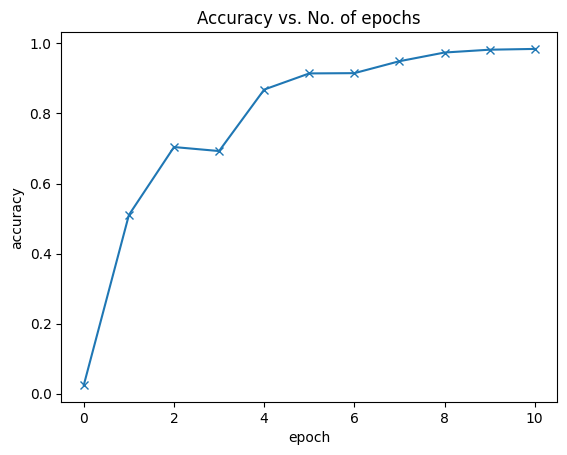

In [51]:
# Plotting the accuracies using the defined helper function
plot_accuracies(history)

### 7.2: Plotting Learning Rate

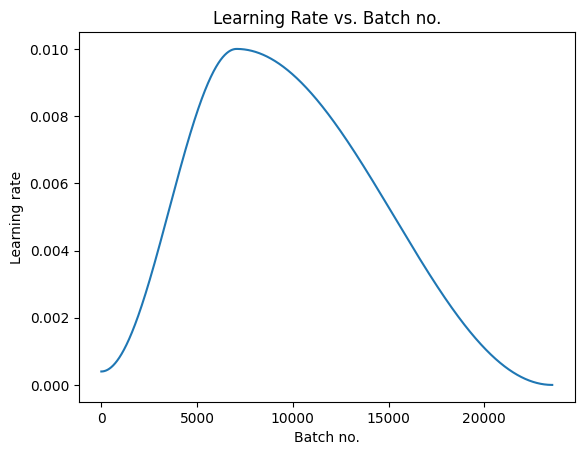

In [52]:
# Plotting the learning rate schedule using the defined helper function
plot_lrs(history)

## 9: Saving the model

In [53]:
# Define the path where the model should be saved. This includes the filename and the file extension.
PATH = '/content/plant-disease-model-complete.pth'

# Use torch.save to save the entire model object to the specified path.
torch.save(model.state_dict(), PATH)

# Check if the file exists and then print confirmation
if os.path.exists(PATH):
    print(f"Model state dictionary successfully saved to {PATH}")
else:
    print(f"Failed to save the model to {PATH}")

Model state dictionary successfully saved to /content/plant-disease-model-complete.pth
